## Exploring CUPED (aka Control Variates)

Imagine for a moment that you are a data scientist. A few engineers at your company have proposed a new feature, and you are tasked with running an experiment to assess the feature's potential impact on revenue. The experiment runs smoothly, and the returns seem promising. However, when you reach the analysis stage, you get a p-value of 0.07, just above the typical p<0.05 threshold for significance. Hesitant to advocate for the feature without stronger evidence, you collect more data and obtain a p-value below 0.05. 

The scenario presented above is less than ideal. Each data point we collect costs time and money, so we would like to minimize the amount of data we need to make strong statistical claims. In general, we can only increase our statistical confidence in two ways: collect more data or decrease variance in our estimates. Since we want to minimize type spent in experimentation (and therefore provide better features faster), we need to think about decreasing the variance in our estimates. There are *lots* of ways to do this, varying from changes in experimental design to refining our estimator. Here I'm going to focus on CUPED, also known as control variates, a simple way to reduce variance using pre-experimental data. 

Note: This post is inspired significantly by a blog post by Matteo Courthoud. The writing and code is my own, but I'm largely replicating his work!

### Preliminaries

Let's start with some notation. To keep this post brief, I'm going to assume some familiarity with causal inference and the potential outcomes framework. Let $Y$ be our outcome of interest and $T$ be our treatment indicator such that $T=0$ is the control group and $T=1$ denotes the treatment group. Suppose we have $n$ units in our experiment. In a simple random experiment, we randomly assign $n_t$ units to treatment and assign the remainder, 
$n_c=n-n_t$, to control. 

In causal inference, the most common quantity of interest is the *average treatment effect*, that is the difference in the average outcome of treatment and control. We use $\tau$ to denote the true average treatment effect (ATE).

### The Default: Difference-in-Means

A natural estimator of the ATE is
$$\hat{\tau}_{diff} = \frac{1}{n_t}\sum_{i=1}^nY_iT_i - \frac{1}{n_c}\sum_{i=1}^nY_i(1-T_i)$$
where we take the difference in the observed average outcome between treatment and control. Equivalently, we can use a linear regression of the form
$$Y = \hat{\alpha} + \hat{\tau}_{reg} T$$
to obtain $\hat{\tau}_{diff}=\hat{\tau}_{reg}$. This estimator, referred to as the difference-in-means (DiM) method, is compelling in its simplicity. However, DiM does not provide any mechanism for reducing variance, instead requiring more data to reduce uncertainty. In most experiments, we have some information that is related to the outcome. If that information is independent of the treatment assignment, we can use it to reduce uncertainty in our estimate. For example, in a clinical trial, a patient's age may be related to their risk of disease. When performing our analysis, we want to account for the relationship between age and disease risk to maximize efficiency.

### Simple Yet Powerful: CUPED
Here is where CUPED comes to the rescue. Suppose we have some variable $X$ that we've measured before the experiment begins. In the simplest terms, CUPED subtracts out the variance in $Y$ that can be explained by $X$, thereby reducing variance in our estimates. $X$ here is referred to as a *control variate*. Given a control variate $X$, we define $\tilde{Y} = Y - \theta(X-\mathbb{E}[X])$, where $\theta$ is any constant. We then apply DiM to $\tilde{Y}$:
$$\hat{\tau}_{cv} =  \frac{1}{n_t}\sum_{i=1}^n\tilde{Y}_iT_i - \frac{1}{n_c}\sum_{i=1}^n\tilde{Y}_i(1-T_i)$$
The resulting estimator $\hat{\tau}_{cv}$ is an unbiased estimator with $var(\hat{\tau}_{cv}) \leq var(\hat{\tau}_{diff})$.

This feels a little too easy, right? We get reduced variance by just subtracting something from $Y$? That's part of the beauty of CUPED! The theory is simple to understand as well. 

First, let's demonstrate unbiasedness, that is $\mathbb{E}[\hat{\tau}_{cv}] = \tau$. We can rewrite the CUPED estimator as
$$\hat{\tau}_{cv} =  \frac{1}{n_t}\sum_{i=1}^n(Y_i - \theta(X-\mathbb{E}[X]))T_i - \frac{1}{n_c}\sum_{i=1}^n(Y_i - \theta(X-\mathbb{E}[X]))(1-T_i)$$
Since we are using random assignment, and since $X$ is measured *before* the experiment, $\mathbb{E}[X|T=1] = \mathbb{E}[X|T=0]$. Therefore, we don't incur  bias due to imbalance between treatment and control. Moreover, $\mathbb{E}[X - \mathbb{E}[X]] = 0$, so we are adding a mean zero random variable, maintaining unbiasedness. 

Moving on to the variance, we can see that
$$var(\tilde{Y}) = var(Y - \theta(X-\mathbb{E}[X])) = var(Y) + \theta^2var(X) - 2\theta cov(Y,X)$$
since $\mathbb{E}[X]$ is a constant. This equation tells us two things. 
1. We want to use a variable $X$ that is highly correlated with $Y$
2. We want to pick a value for $\theta$ that minimizes $var(\tilde{Y})$

Finding a suitable $X$ will vary based on the context of the problem. It turns out, however, that the best value for $\theta$ is $\frac{cov(Y,X)}{var(X)}$. This is the same as regressing $Y$ on $X$! Therefore, the procedure for CUPED simply adds another layer of linear regression to the DiM procedure above. 

### DiM and CUPED in Python

Now that we've talked about the theory, let's work through a practical example using simulation in Python. We're going to anchor our simulation in the approach laid out in the original paper by Deng et al. In particular, we are going to consider an online experiment on users of a platform. We want to evaluate whether our treatment has some impact on a metric $Y$. For each user, we measure $Y$ before triggering the experiment (pre-trigger) and after triggering the experiment (post-trigger). We'll refer to the pre- and post-trigger observations as $Y_{pre}$ and $Y_{post}$, respectively. $Y_{pre}$ should be strongly correlated with $Y_{post}$, even if the treatment effect is significant. Therefore, we use the pre-trigger values as the control variate. 

We start by importing the relevant packages and simulating a dataset. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from cuped_utils import *
data = cuped_generator(
    sample_size = 500,
    t_proportion = 0.5,
    effect_size = 0.5,
)

In our dataset, we have a ground-truth treatment effect of 0.5. Additionally, we observe 500 units, and each unit has a 50% chance of being assigned to treatment. 

First, let's take a quick peek at our data. 

In [2]:
data.iloc[:6,:]

,Treatment,Pre_trigger,Post_trigger,Pre_normalized
0,1,4.924905,8.325782,-0.147397
1,0,4.048135,5.801409,-1.024167
2,0,5.334973,8.425400,0.262671
3,0,2.902762,6.273420,-2.169539
4,0,3.759250,5.695983,-1.313051
5,1,3.175777,6.914893,-1.896525


'Treatment' contains the treatment indicator, 'Pre_trigger' and 'Post_trigger' are $Y_{pre}$ and $Y_{post}$, respectively, and 'Pre-normalized' is $Y_{pre}-\mathbb{E}[Y_{pre}]$. 

Let's take a look at the estimates from DiM and CUPED. As mentioned above, we can calculated $\hat{\tau}_{diff}$ by regression $Y$ on $T$ with an intercept term. Note that `smf.ols()` automatically adds an intercept to the regression.

In [3]:
reg = smf.ols("Post_trigger ~ Treatment",data).fit()
reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                 500   F-statistic:                     9.640
Covariance Type:                  HC2   Prob (F-statistic):            0.00201
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0120      0.132     60.518      0.000       7.752       8.272
Treatment      0.6232      0.201      3.105      0.002       0.229       1.018
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

The DiM estimate isn't far off, and the p-value is quite smaller that 0.05. So DiM would seem to suffice in this scenario!

Next, let's take a look at CUPED. For $\hat{\tau}_{cv}$, we first regress $Y_{post}$ on $Y_{pre} - \mathbb{E}[Y_{pre}]$ to obtain the optimal $\theta$. Then, we calculate $$\tilde{Y}_{post} = Y_{post} - \theta(Y_{pre} - \mathbb{E}[Y_{pre}])$$
marginalizing out the variance in $Y_{post}$ attributable to $Y_{pre}$. Finally, we perform DiM on $\tilde{Y}_{post}$ by regressing $\tilde{Y}_{post}$ on $T$. 

In [4]:
cuped_lm = sm.OLS(data['Post_trigger'], data['Pre_normalized']).fit()
theta = cuped_lm.params[0]
data['Post_cuped'] = data['Post_trigger'] - theta*data['Pre_normalized']
cuped_reg = smf.ols("Post_cuped ~ Treatment", data).fit()
cuped_reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Post_cuped   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
No. Observations:                 500   F-statistic:                     33.29
Covariance Type:                  HC2   Prob (F-statistic):           1.40e-08
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0540      0.065    124.469      0.000       7.927       8.181
Treatment      0.5357      0.093      5.770      0.000       0.353       0.718
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

We can see that the standard error in CUPED is roughly half that of DiM! The CUPED confidence interval is half the length of the DiM confidence interval. These are huge gains for such a low-cost and simple method. 

### What About Regression Adjustment?

Okay, CUPED seems great, but it's also a relatively new idea. What were people doing before CUPED? 

Regression adjustment is the classical way of adjusting for additional variables. All regression adjustment does is add a term for $X$ into DiM regression:
$$Y = \hat{\alpha} + \hat{\tau}_{adj_1} T + \hat{\beta} X$$
$\hat{\tau}_{adj_1}$, however, can be biased in some circumstances, particularly when the probability of treatment is not $\frac{1}{2}$.  Instead, it is more theoretically appropriate to include an interaction term between the treatment indicator and mean-centered $X$:
$$Y = \hat{\alpha} + \hat{\tau}_{adj_2} T + \hat{\beta} X + \hat{\gamma} (X-\mathbb{E}[X])*T$$
which allows $\hat{\tau}_{adj_2}$ to be unbiased. 

Note: We don't need to believe that our data-generating process is linear for regression adjustment to reduce variance and maintain unbiasedness. OLS finds the best linear projection from $X$ to $Y$ which will reduce variance even if the data themselves are not linearly related. If we use robust estiamtes of covariance, our p-values and confidence intervals will remain valid even with heteroskedastic residuals. 

In [8]:
reg_adj = smf.ols(
    formula="Post_trigger ~ Treatment + Pre_trigger + Treatment:Pre_normalized",
    data=data).fit()
reg_adj.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
No. Observations:                 500   F-statistic:                     665.8
Covariance Type:                  HC2   Prob (F-statistic):          1.89e-173
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.0532      0.065    124.202      0.000       7.926       8.181
Treatment                    0.5360      0.093      5.757      0.000       0.353       0.719
Pre_normalized               0.9568      0.033     29.373      0.000       0.893       1.021
Treatment:Pre_normalized     0.0303      0.045      0.680      0.497      -0.057       0.118
============================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

Surprisingly, CUPED and regression adjustment return very similar estimates and similar standard errors. To make sure this result isn't just a fluke of random chance, let's simulate a few thousand datasets. In particular, we'll look at the distribution of point estimates for difference-in-means, CUPED, and regression adjustment. If CUPED and regression adjustment perform similarly, we would expect their point estimate distributions to be roughly the same. 

<AxesSubplot:xlabel='estimate', ylabel='Density'>

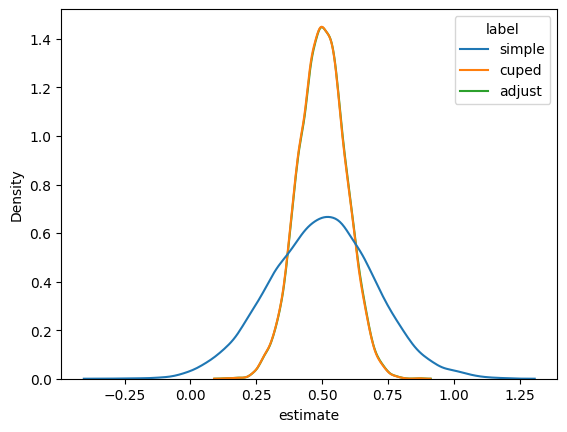

In [6]:
n = 10000
sample_size = 500
simple, cuped, adjust = many_cuped_sims(n_sims=n)
df = pd.DataFrame()
simple_df = pd.DataFrame({'label':['simple']*n, 'estimate':simple})
cuped_df = pd.DataFrame({'label':['cuped']*n, 'estimate':cuped})
adjust_df = pd.DataFrame({'label':['adjust']*n, 'estimate':adjust})

df = df.append([simple_df, cuped_df, adjust_df])
sns.kdeplot(x='estimate', hue = 'label', data=df)

We can see that CUPED and regression adjustment appear to have the same point estimate distribution. 

The results of our simulations beg the question, are CUPED and regression adjustment the same? The answer is somewhat nuanced. In the original 2013 paper by Deng et al., CUPED is conceptualized as not only including linear functions of $X$, but general functions $f(X)$ as well. We could define $\tilde{Y}_f = Y - \theta (f(X) - \mathbb{E}[f(X)])$, allowing us to correct for a variety of relationships between $Y$ and $X$. 

Deng et al. re-define and expand CUPED in a 2023 paper. In particular, they formulate CUPED as adding a mean-zero random variable, referred to as an 'augmentation', to any estimator of the ATE. To demonstrate the flexibility of their augmentation perspective, Deng et al. show that regression adjustment can be written as $\hat{\tau}_{diff} - \hat{\tau}_0$. Furthermore, we can show that (traditional) CUPED and regression adjustment (with an interaction term) are asymptotically equivalent! So at least asymptotically, CUPED and regression adjustment are indeed the same thing. 

It turns out that nearly every "reasonable" estimator of the ATE can be written as 
$$\begin{equation}
\hat{\tau} = \hat{\tau}_{diff} - \hat{\tau}_0
\end{equation}$$
where $\hat{\tau}_0$ is a function of $T$ and $X$, and $\mathbb{E}[\hat{\tau}_0]=0$. Equation (1) implies that essentially every reasonable estimator is a type of CUPED (i.e. augmented) estimator. While this is a bit of an oversimplification, it's useful to think of ATE estimators as augmenting the DiM. 

Note: Equation (1) is a result from semiparametric efficiency theory and has been known for a few decades. In some sense, it's unfair to call all reasonable estimators special cases of CUPED, since CUPED was only formulated in 2013. It may be more appropriate to call CUPED a specific way to frame semiparametric efficiency theory rather than the reverse. 

Note: Semiparametric efficiency theory is the theoretical basis for using machine learning in causal inference. I gloss over it here for brevity, but I may discuss it in more detail in a future post. Additionally, the term 'reasonable' can be described more rigorously. If you would like to learn more, this paper has some useful discussion of the theory I've introduced so far.

An interesting consequence of Equation (1) is that many estimators are equivalent asymptotically. How should we choose between the many choices we have? Though estimators may behave similarly asymptotically, they typically have different behavior in finite samples. Therefore, we should consider the finite sample implications of our estimator before implementing it. Outside of finite sample behavior, the choice of estimator largely depends on context and personal preference.

Let's focus on regression adjustment and CUPED. In small samples, CUPED will be able to obtain an estimate of $\theta$ since $\theta$ is estimated jointly for treatment and control. Regression adjustment with an interaction term, however, essentially performs separate regressions for treatment and control. So if the treatment group is small, we may get strange results. On the other hand, regression adjustment is more familiar to certain audiences, so presenting results using regression adjustment may be more natural. 

Okay, we've covered a lot of ground! The main takeaways are:
1. CUPED is a simple but powerful method to reduce variance
2. CUPED and regression adjustment are asymptotically the same
3. The choice between the two depends on context and personal taste

Next time, we'll look into nonlinear adjustments and augmentations. I'll delve into a few approaches to using machine learning to perform causal inference and compare ML models to linear ones.

#### Citations

Matteo Courthoud. 2024. Understanding CUPED. 
 - https://matteocourthoud.github.io/post/cuped/

Alex Deng, Ya Xu, Ron Kohavi, and Toby Walker. 2013. Improving the sensitivity of online controlled experiments by utilizing pre-experiment data. In Proceedings of the sixth ACM international conference on Web search and data mining (WSDM '13). Association for Computing Machinery, New York, NY, USA, 123–132. https://doi.org/10.1145/2433396.2433413
 - https://dl.acm.org/doi/abs/10.1145/2433396.2433413

Alex Deng, Luke Hagar, Nathaniel Stevens, Tatiana Xifara, Lo-Hua Yuan, & Amit Gandhi. 2023. From Augmentation to Decomposition: A New Look at CUPED in 2023. 
 - https://arxiv.org/abs/2312.02935

Winston Lin. 2013. Agnostic notes on regression adjustments to experimental data: Reexamining Freedman’s critique. The Annals of Applied Statistics, Ann. Appl. Stat. 7(1), 295-318.
 - https://projecteuclid.org/journals/annals-of-applied-statistics/volume-7/issue-1/Agnostic-notes-on-regression-adjustments-to-experimental-data--Reexamining/10.1214/12-AOAS583.full

Anastasios A Tsiatis, Marie Davidian, Min Zhang, Xiaomin Lu . 2008. Covariate adjustment for two-sample treatment comparisons in randomized clinical trials: a principled yet flexible approach. Stat Med. doi: 10.1002/sim.3113. PMID: 17960577; PMCID: PMC2562926.
 - https://pmc.ncbi.nlm.nih.gov/articles/PMC2562926/

<AxesSubplot:xlabel='estimate', ylabel='Density'>

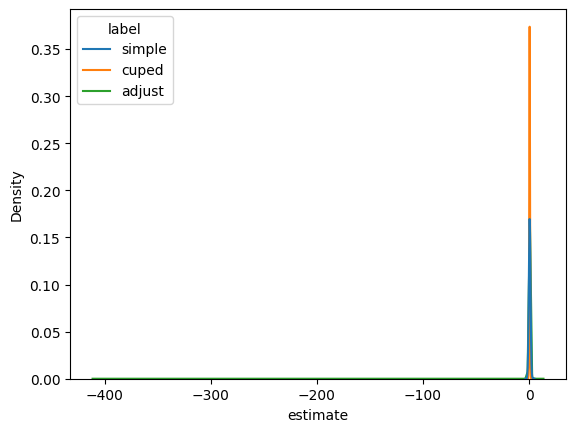

In [7]:
# testing if t_proportion impacts cuped variance
# can get weird adjust results if t is not observed often enough
n = 10000
sample_size = 50
simple, cuped, adjust = many_cuped_sims(
    n_sims=n,
    sample_size=sample_size,
    t_proportion=0.2)
df = pd.DataFrame()
simple_df = pd.DataFrame({'label':['simple']*n, 'estimate':simple})
cuped_df = pd.DataFrame({'label':['cuped']*n, 'estimate':cuped})
adjust_df = pd.DataFrame({'label':['adjust']*n, 'estimate':adjust})

df = df.append([simple_df, cuped_df, adjust_df])
sns.kdeplot(x='estimate', hue = 'label', data=df)